<a href="https://colab.research.google.com/github/Anup8777/TensorFlow_DeepLearning/blob/master/DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DenseNet and tf.function

## Without tf.function

In [1]:
import tensorflow as tf
from tensorflow.keras import layers as layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.optimizers import Adam
import tensorboard
import datetime
import warnings
import os
from sklearn import metrics
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10, cifar100
import numpy as np
import os
import time

%load_ext tensorboard

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
#drive.mount('/content/drive/')

In [0]:
logdir = os.path.join("logs", datetime.datetime.now( ).strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
warnings.filterwarnings('ignore')

In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [0]:
def resnet_layer(inputs, num_filters=16, kernel_size=3, strides=1, activation='relu',batch_normalization=False,conv_first=True):
    
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [0]:
def resnet_v1(input_shape, depth, num_classes=10):
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x, num_filters=num_filters,strides=strides)
            y = resnet_layer(inputs=y,num_filters=num_filters, activation=None)
            if stack > 0 and res_block == 0:  
                x = resnet_layer(inputs=x,num_filters=num_filters, kernel_size=1,strides=strides, activation=None, batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [7]:
batch_size = 256  # orig paper trained all networks with batch_size=128
epochs = 50
data_augmentation = True
num_classes = 10

subtract_pixel_mean = True

n = 3
depth = n * 6 + 2

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
input_shape = x_train.shape[1:]

170500096/170498071 [==============================] - 6s 0us/step


In [0]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

In [0]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [10]:
model = resnet_v1(input_shape=input_shape, depth=depth)
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr_schedule(0)),metrics=['accuracy'])
#model.summary()

Learning rate:  0.001


In [0]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,monitor='val_acc',verbose=1, save_best_only=True)
lr_scheduler = LearningRateScheduler(lr_schedule)

callbacks = [checkpoint, lr_scheduler]

In [12]:
t1 = time.time()
model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
t2 = time.time()- t1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
Learning rate:  0.001
50000/50000 [==============================] - 41s 815us/step - loss: 2.1374 - accuracy: 0.2665 - val_loss: 1.8080 - val_accuracy: 0.3714
Epoch 2/50
Learning rate:  0.001
50000/50000 [==============================] - 33s 669us/step - loss: 1.6941 - accuracy: 0.4277 - val_loss: 1.5978 - val_accuracy: 0.4547
Epoch 3/50
Learning rate:  0.001
50000/50000 [==============================] - 33s 666us/step - loss: 1.4996 - accuracy: 0.5021 - val_loss: 1.4708 - val_accuracy: 0.5231
Epoch 4/50
Learning rate:  0.001
50000/50000 [==============================] - 33s 667us/step - loss: 1.3637 - accuracy: 0.5552 - val_loss: 1.3299 - val_accuracy: 0.5673
Epoch 5/50
Learning rate:  0.001
50000/50000 [==============================] - 33s 668us/step - loss: 1.2632 - accuracy: 0.5918 - val_loss: 1.2598 - val_accuracy: 0.6007
Epoch 6/50
Learning rate:  0.001
50000/50000 [==============================] - 33s 669us/step 

In [13]:
t2

1678.6480567455292

## tf.function

[6]


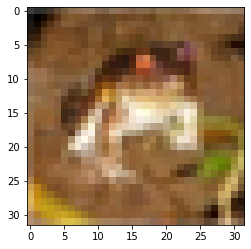

In [14]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print(train_labels[0])
plt.imshow(train_images[0])

data = tf.data.Dataset.from_tensor_slices(
    (train_images.reshape([-1, 32, 32, 3]).astype(np.float32) / 255, train_labels.astype(np.int32)))
data = data.shuffle(buffer_size=50000).batch(128).repeat()

test_data = tf.data.Dataset.from_tensor_slices(
    (test_images.reshape([-1, 32, 32, 3]).astype(np.float32) / 255, test_labels.astype(np.int32))).batch(128)

In [0]:
train_steps = int(epochs * len(train_images))/128

opt = tf.optimizers.Adam()

loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

train_acc_metric = tf.metrics.SparseCategoricalAccuracy()

In [0]:
@tf.function
def train_step(imgs, lbls, model):
    with tf.GradientTape() as tape:
        logits = model(imgs)
        xent = loss_fn(lbls, logits)

    varis = model.trainable_weights
    grads = tape.gradient(xent, varis)
    opt.apply_gradients(zip(grads, varis))

    return xent, logits

In [17]:
start = time.time()
for step, (img_batch, lbl_batch) in enumerate(data):
    if step > train_steps:
        break

    xent, logits = train_step(img_batch, lbl_batch, model)

    if not step % 10000:
        train_acc_metric(lbl_batch, logits)
        acc = train_acc_metric.result()
        print("Loss: {} Accuracy: {}".format(xent, acc))
        train_acc_metric.reset_states()

stop = time.time()
print("took {} seconds\n".format(stop-start))
        #start = time.time()

Loss: 1.804630994796753 Accuracy: 0.671875
Loss: 2.3674001693725586 Accuracy: 0.09375
took 1477.9122109413147 seconds



Text(0.5, 1.0, 'Comparison of execution time with tf.function')

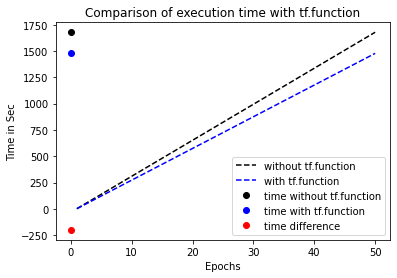

In [18]:
xvalues = np.linspace(1,50,50)
y1values = np.linspace(1,t2,50)
y2values = np.linspace(1,(stop-start),50)

plt.plot(xvalues, y1values, 'k--', label='without tf.function')
plt.plot(xvalues, y2values, 'b--', label='with tf.function')
plt.plot(t2, 'ko', label='time without tf.function')
plt.plot((stop-start),'bo',label='time with tf.function')
plt.plot((stop-start - t2), 'ro',label='time difference')
plt.xlabel('Epochs')
plt.ylabel('Time in Sec')
plt.legend(loc='best')
plt.title('Comparison of execution time with tf.function')

In [27]:
test_acc_metric = tf.metrics.SparseCategoricalAccuracy()
for img_batch, lbl_batch in test_data:
    test_acc_metric(lbl_batch, model(img_batch))

test_acc_metric.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

## DenseNet for CIFAR10

In [0]:
epochs = 150
train_steps = int(epochs * len(train_images))/128

In [0]:
DenseNet121 = tf.keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=((32,32,3)),
    pooling=None,
    classes=num_classes,
)

DenseNet121_c100 = tf.keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=((32,32,3)),
    pooling=None,
    classes=num_classes,
)

Using DenseNet functional API to build the model.

In [47]:
DenseNet121.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 38, 38, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 16, 16, 64)   9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [0]:
@tf.function
def train_step(imgs, lbls):
    with tf.GradientTape() as tape:
        logits = DenseNet121(imgs)
        xent = loss_fn(lbls, logits)

    varis = DenseNet121.trainable_weights
    grads = tape.gradient(xent, varis)
    opt.apply_gradients(zip(grads, varis))

    return xent, logits

In [49]:
start = time.time()
for step, (img_batch, lbl_batch) in enumerate(data):
    if step > train_steps:
        break

    xent, logits = train_step(img_batch, lbl_batch)

    if not step % 10000:
        train_acc_metric(lbl_batch, logits)
        acc = train_acc_metric.result()
        print("Loss: {} Accuracy: {}".format(xent, acc))
        train_acc_metric.reset_states()

stop = time.time()
print("took {} seconds\n".format(stop-start))
        #start = time.time()

Loss: 9.684097290039062 Accuracy: 0.000732421875
Loss: 1.2060661315917969 Accuracy: 0.10711669921875
Loss: 0.6264679431915283 Accuracy: 0.104736328125
Loss: 0.6071826219558716 Accuracy: 0.10565185546875
Loss: 0.9457005858421326 Accuracy: 0.102783203125
Loss: 1.0126498937606812 Accuracy: 0.10418701171875
took 12725.662535905838 seconds



In [50]:
test_acc_metric = tf.metrics.SparseCategoricalAccuracy()
for img_batch, lbl_batch in test_data:
    test_acc_metric(lbl_batch, DenseNet121(img_batch))

test_acc_metric.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.10465589>

## DenseNet for CIFAR 100

In [0]:
DenseNet121_c100 = tf.keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=((32,32,3)),
    pooling=None,
    classes=100,
)

[19]


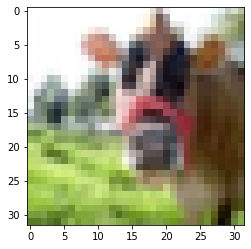

In [54]:
(train_images_c100, train_labels_c100), (test_images_c100, test_labels_c100) = cifar100.load_data()
print(train_labels_c100[0])
plt.imshow(train_images_c100[0])

data_c100 = tf.data.Dataset.from_tensor_slices(
    (train_images_c100.reshape([-1, 32, 32, 3]).astype(np.float32) / 255, train_labels_c100.astype(np.int32)))
data_c100 = data_c100.shuffle(buffer_size=50000).batch(128).repeat()

test_data_c100 = tf.data.Dataset.from_tensor_slices(
    (test_images_c100.reshape([-1, 32, 32, 3]).astype(np.float32) / 255, test_labels_c100.astype(np.int32))).batch(128)

In [0]:
@tf.function
def train_step(imgs, lbls):
    with tf.GradientTape() as tape:
        logits = DenseNet121_c100(imgs)
        xent = loss_fn(lbls, logits)

    varis = DenseNet121_c100.trainable_weights
    grads = tape.gradient(xent, varis)
    opt.apply_gradients(zip(grads, varis))

    return xent, logits

In [0]:
start = time.time()
for step, (img_batch, lbl_batch) in enumerate(data_c100):
    if step > train_steps:
        break

    xent, logits = train_step(img_batch, lbl_batch)

    if not step % 10000:
        train_acc_metric(lbl_batch, logits)
        acc = train_acc_metric.result()
        print("Loss: {} Accuracy: {}".format(xent, acc))
        train_acc_metric.reset_states()

stop = time.time()
print("took {} seconds\n".format(stop-start))
        #start = time.time()

Loss: 9.852657318115234 Accuracy: 6.103515625e-05
Loss: 3.3022279739379883 Accuracy: 0.01129150390625
Loss: 1.7604281902313232 Accuracy: 0.0164794921875
Loss: 1.9296777248382568 Accuracy: 0.01617431640625
Loss: 1.8409537076950073 Accuracy: 0.02020263671875
Loss: 1.6595362424850464 Accuracy: 0.01495361328125


In [0]:
test_acc_metric = tf.metrics.SparseCategoricalAccuracy()
for img_batch, lbl_batch in test_data_c100:
    test_acc_metric(lbl_batch, DenseNet121(img_batch))

test_acc_metric.result()